In [501]:
import os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 300

from forex_python.converter import CurrencyRates

In [502]:
# Read in data that was processed in OpenRefine
FILENAME = "raw-roast-reviews-openrefine.csv"
FILEPATH = os.path.join("data", FILENAME)
df_raw = pd.read_csv(FILEPATH)

In [503]:
def tweak_df(df):
    return (df
            .replace('na', np.nan)
            .dropna(subset=['origin_country_cluster', 'roaster_location', 'roast_level', 'body', 'aroma'])
            .assign(origin_country=lambda df_: (df_['origin_country_cluster']
                                                .str.split(',')
                                                .str[-1]
                                                .str.strip()
                                                ),
                    origin_region=lambda df_: (df_['origin_country_cluster']
                                               .str.split(',')
                                               .str[:-1]
                                               .str.join(',')
                                               .str.strip()
                                               ),
                    review_date = lambda df_: pd.to_datetime(df_['review_date'], format="%B %Y"),
                    acidity = lambda df_: df_['acidity'].fillna(df_['acidity/structure']),
                    agtron_external = lambda df_: (df_['agtron']
                                                   .str.split('/')
                                                   .str[0].str.strip()
                                                   .replace(['', 'NA', 'g', '0'], np.nan)
                                                   ),
                    agtron_ground = lambda df_: (df_['agtron']
                                                 .str.split('/')
                                                 .str[1].str.strip()
                                                 .replace(['', 'NA', 'wb', '0'], np.nan)),
            )
            .drop(columns=['acidity/structure', 'with_milk', 'bottom_line', 'agtron'])
            .dropna(subset=['acidity']) # drop rows where acidity is still NaN, these are espresso reviews
            .rename(columns={'country': 'roaster_country', 'roaster_location': 'roaster_city', 
                             'located in the administrative territorial entity': 'roaster_region',
                             'coordinate location': 'roaster_coordinates'})
            .assign(origin_region=lambda df_: df_['origin_region'].replace('', np.nan))
            .astype({'agtron_external': 'Int64', 'agtron_ground': 'Int64', 'origin_country': 'category',
                     'acidity': 'float', 'aftertaste': 'Int64', 'aroma': 'float', 'body': 'float',
                     'rating': 'Int64', 'flavor': 'float',})
    )

df = tweak_df(df_raw)

In [504]:
grams_conversions = {
        'ounces': 28.3495,
        'pounds': 453.592,
        'grams': 1,
        'kilograms': 1000
}

currency_map = {
    'CNY': 'CNY',
    '$': 'USD',
    'NT$' : 'TWD',
    'GBP' : 'GBP',
    'HKD$' : 'HKD',
    'Nt$' : 'TWD',
    'RMB' : 'CNY',
    'AED$' : 'AED',
    'KRW$' : 'KRW',
    '£' : 'GBP',
    '$NT$': 'TWD',
    'CAD$' : 'CAD',
    '¥' : 'JPY',
    'pesos' : 'MXN',
    'USD$' : 'USD',
    'US$'  : 'USD',
    '$CAD' : 'CAD',
    'IDR$' : 'IDR',
    'AUD$' : 'AUD',
    '$NT' : 'TWD',
    'NTD$' : 'TWD',
    'NT' : 'TWD',
    'KRW' : 'KRW',
    'RMB$' : 'CNY',
    '$NTD' : 'TWD',
    'CNY$' : 'CNY',
    'THB$' : 'THB',
    'TWD$' : 'TWD',
    'HK$' : 'HKD',
    'E' : 'EUR',
    'GTQ' : 'GTQ',
    'Price:$': 'USD',
    'THB' : 'THB',
 }
# Cleaning up price and units 
quantity = (df['est_price']
 .str.split('[/;]', n=1, expand=True)
 .dropna()
 .rename(columns={0: 'price', 1: 'amount'})
 .loc[:, 'amount']
 .str.replace('oz.*', 'ounces')
 .str.replace('ouncues|onces|ounce$|-ounce|ounces.*$', 'ounces', regex=True)
 .str.replace(r'oz.', 'ounces', regex=False)
 .str.replace(r'g ', 'grams', regex=False)
 .str.replace(r'-gram', ' grams', regex=True)
 .str.replace(r'g. ', 'grams', regex=False)
 .str.replace(r' g.', ' grams', regex=False)
 .str.replace(r'g$', ' grams', regex=True)
 .str.replace(r'\((.*?)\)', '', regex=True)
 .str.replace(r';|\(|\$.*$', '', regex=True)
 .str.replace('tin', '', regex=False)
 .str.replace('  ', ' ', regex=True)
 .str.replace('8 18 grams pouches', '152 grams', regex=False)
 .str.replace('350 grams 12.3 ounces', '350 grams', regex=False)
 .str.strip()
 .mask(lambda x: x.str.contains('capsule|packet|pods|vue|k-cups|sticks|tubes|cups|boxed|discs|can', case=False), np.nan)
 )

quantity_unit= (quantity
                .str.split(' ', expand=True)
                .rename(columns={0: 'quantity', 1: 'unit'})
                # if quantity equals 'pound' set quantity to 1 and unit to pounds
                .assign(unit=lambda df_: df_['unit'].mask(df_['quantity'] == 'pound', 'pound'),
                        quantity = lambda df_: df_['quantity'].mask(df_['quantity'] == 'pound', 1)
                )
                .astype({'quantity': 'float'})
                # convert all units to grams
                .assign(quantity_grams = lambda df_: df_['quantity'] * df_['unit'].map(grams_conversions))
)

price = (df['est_price']
         .str.split('[/;]', n=1, expand=True)
         .loc[:, 0]
         .str.replace(',', '', regex=False)
         # regex to extract the price from the string
        .str.extract(r'(\d+\.\d+|\d+)')
        .loc[:, 0]
        .astype('float')
        .rename('nominal_price')
)

currency = (df['est_price']
         .str.split('[/;]', n=1, expand=True)
         .loc[:, 0]
         .str.replace(',', '', regex=False)
         # regex to extract the price from the string
        .str.replace(r'(\d+\.\d+|\d+)', '', regex=True)
        .str.strip()
        .str.replace(' ', '')
        .map(currency_map, na_action='ignore')
        .rename('currency')
)

df = df.join(quantity_unit, how='left').join(price, how='left').join(currency, how='left')

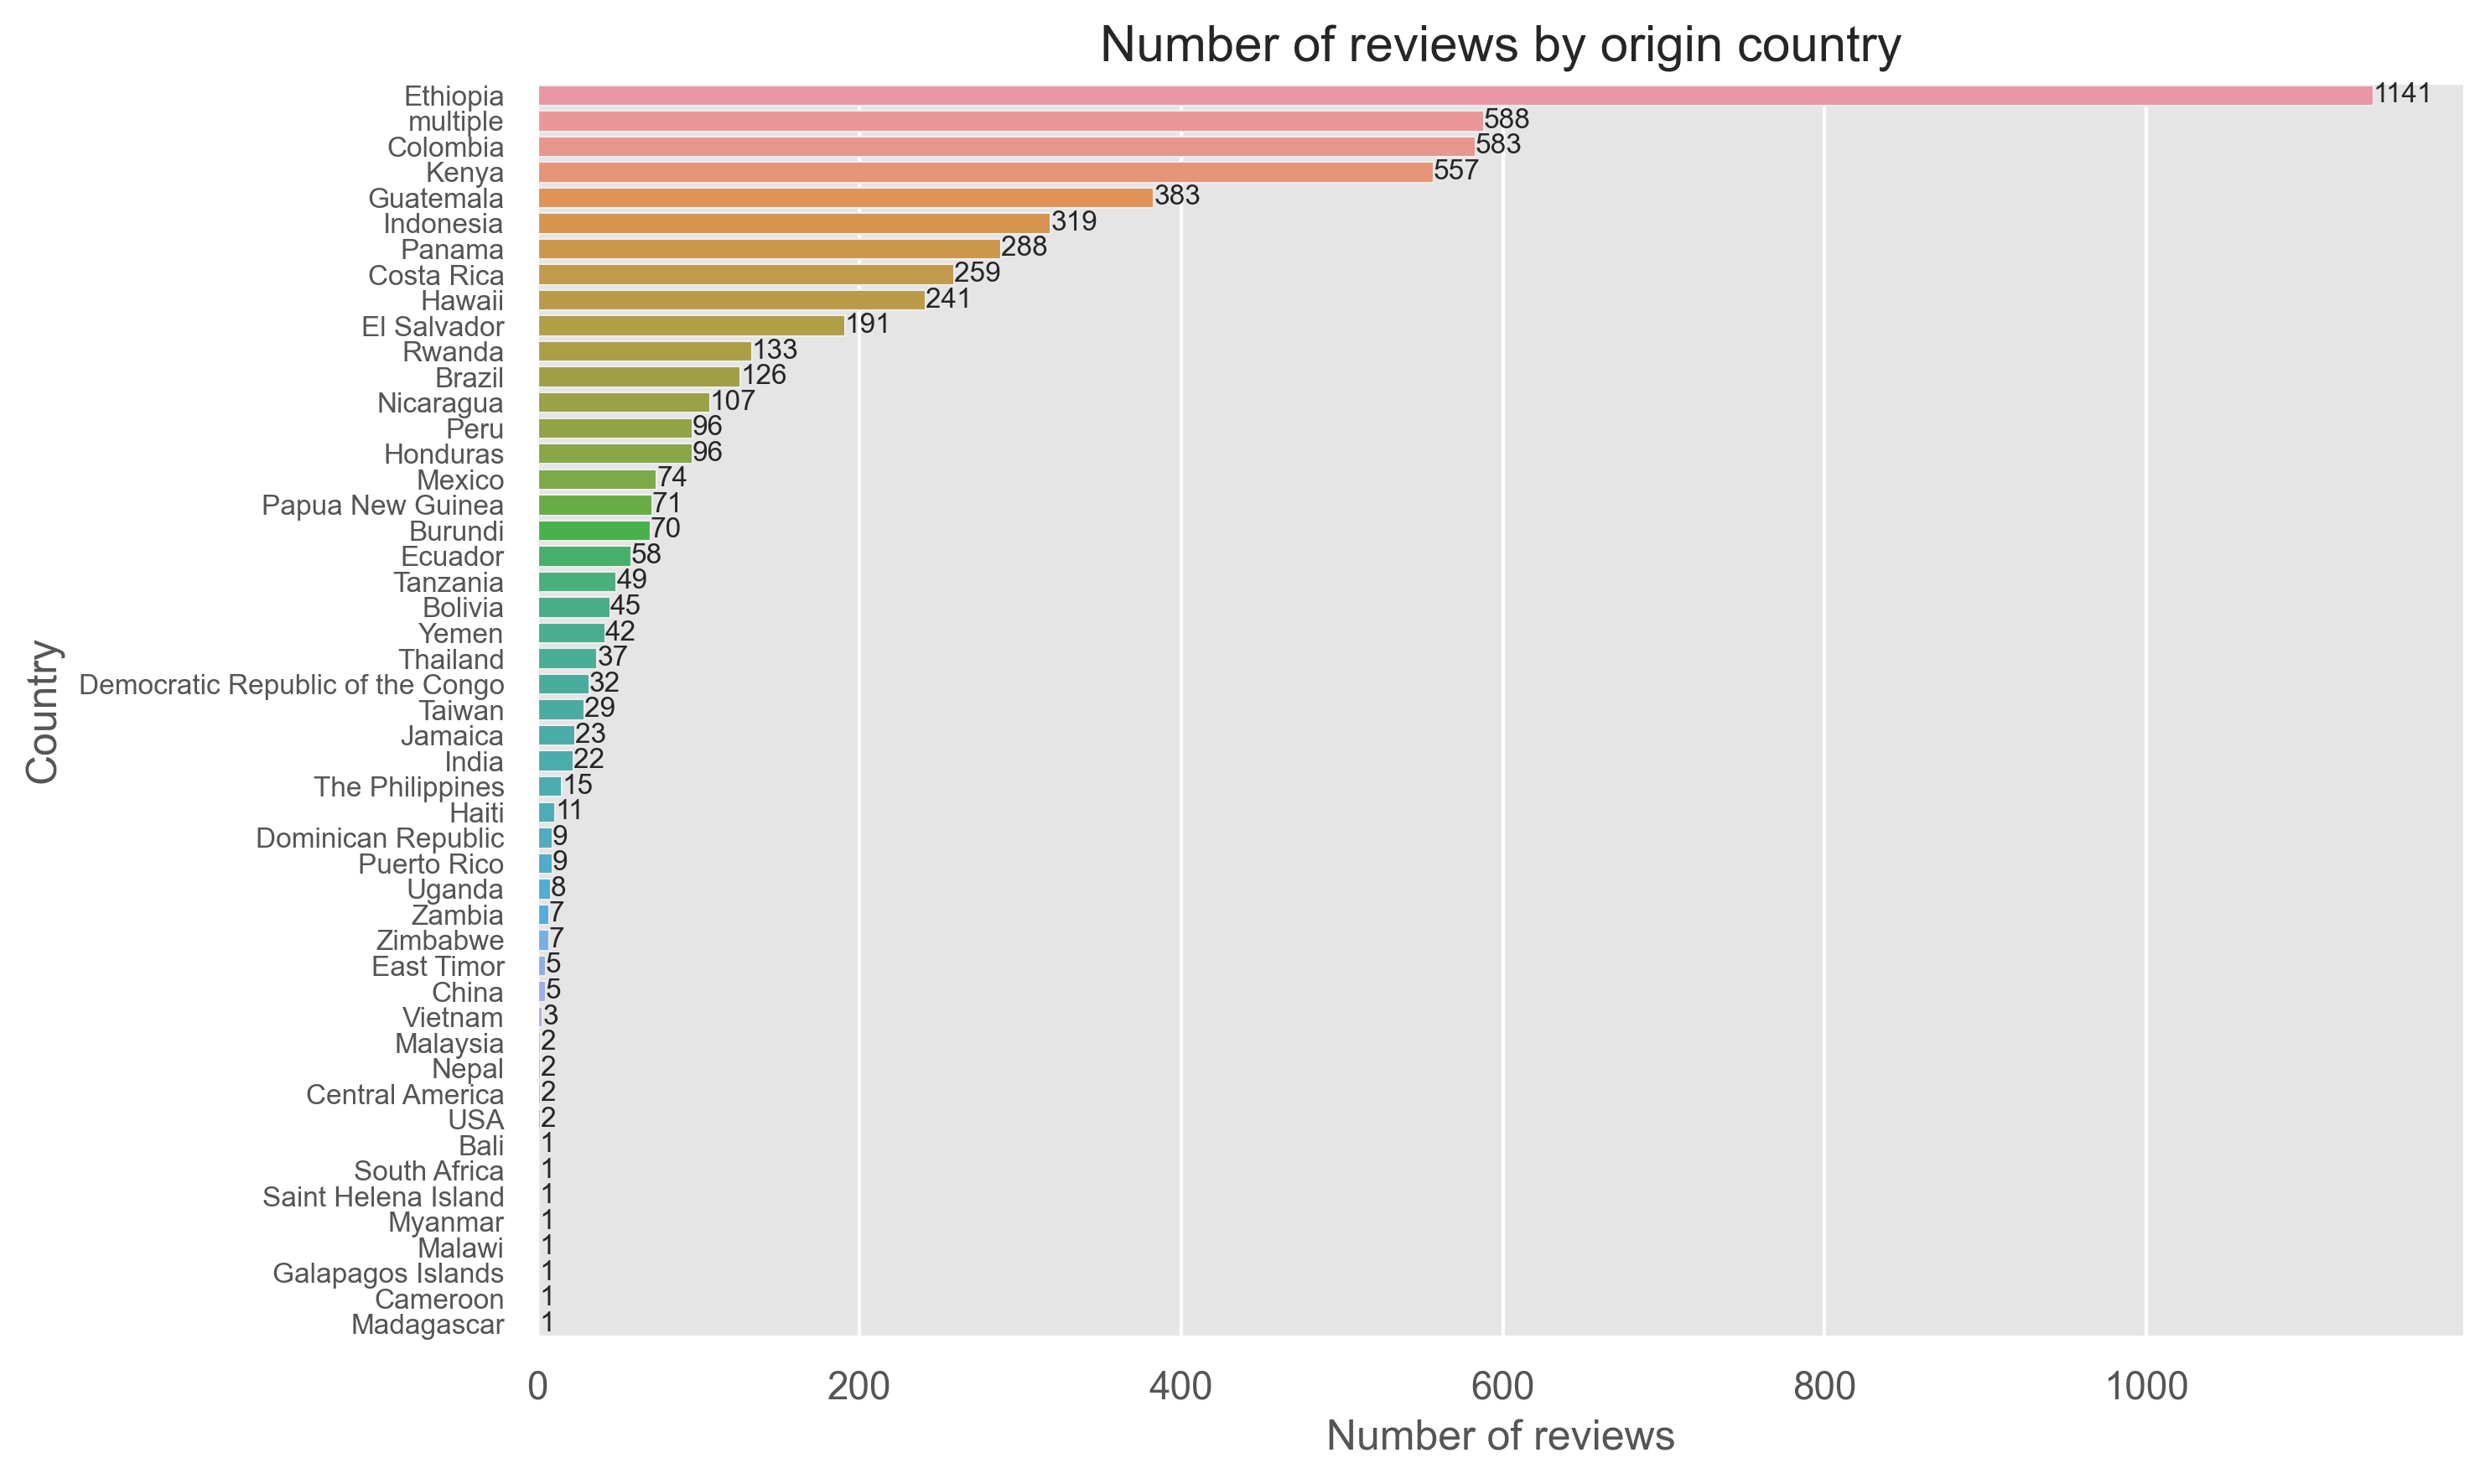

In [506]:
# plot number of reviews by country in seaborn
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='origin_country', data=df, order = df['origin_country'].value_counts().index)
ax.bar_label(ax.containers[0], fontsize=8,)
plt.yticks(fontsize=8)
plt.title('Number of reviews by origin country')
plt.xlabel('Number of reviews')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


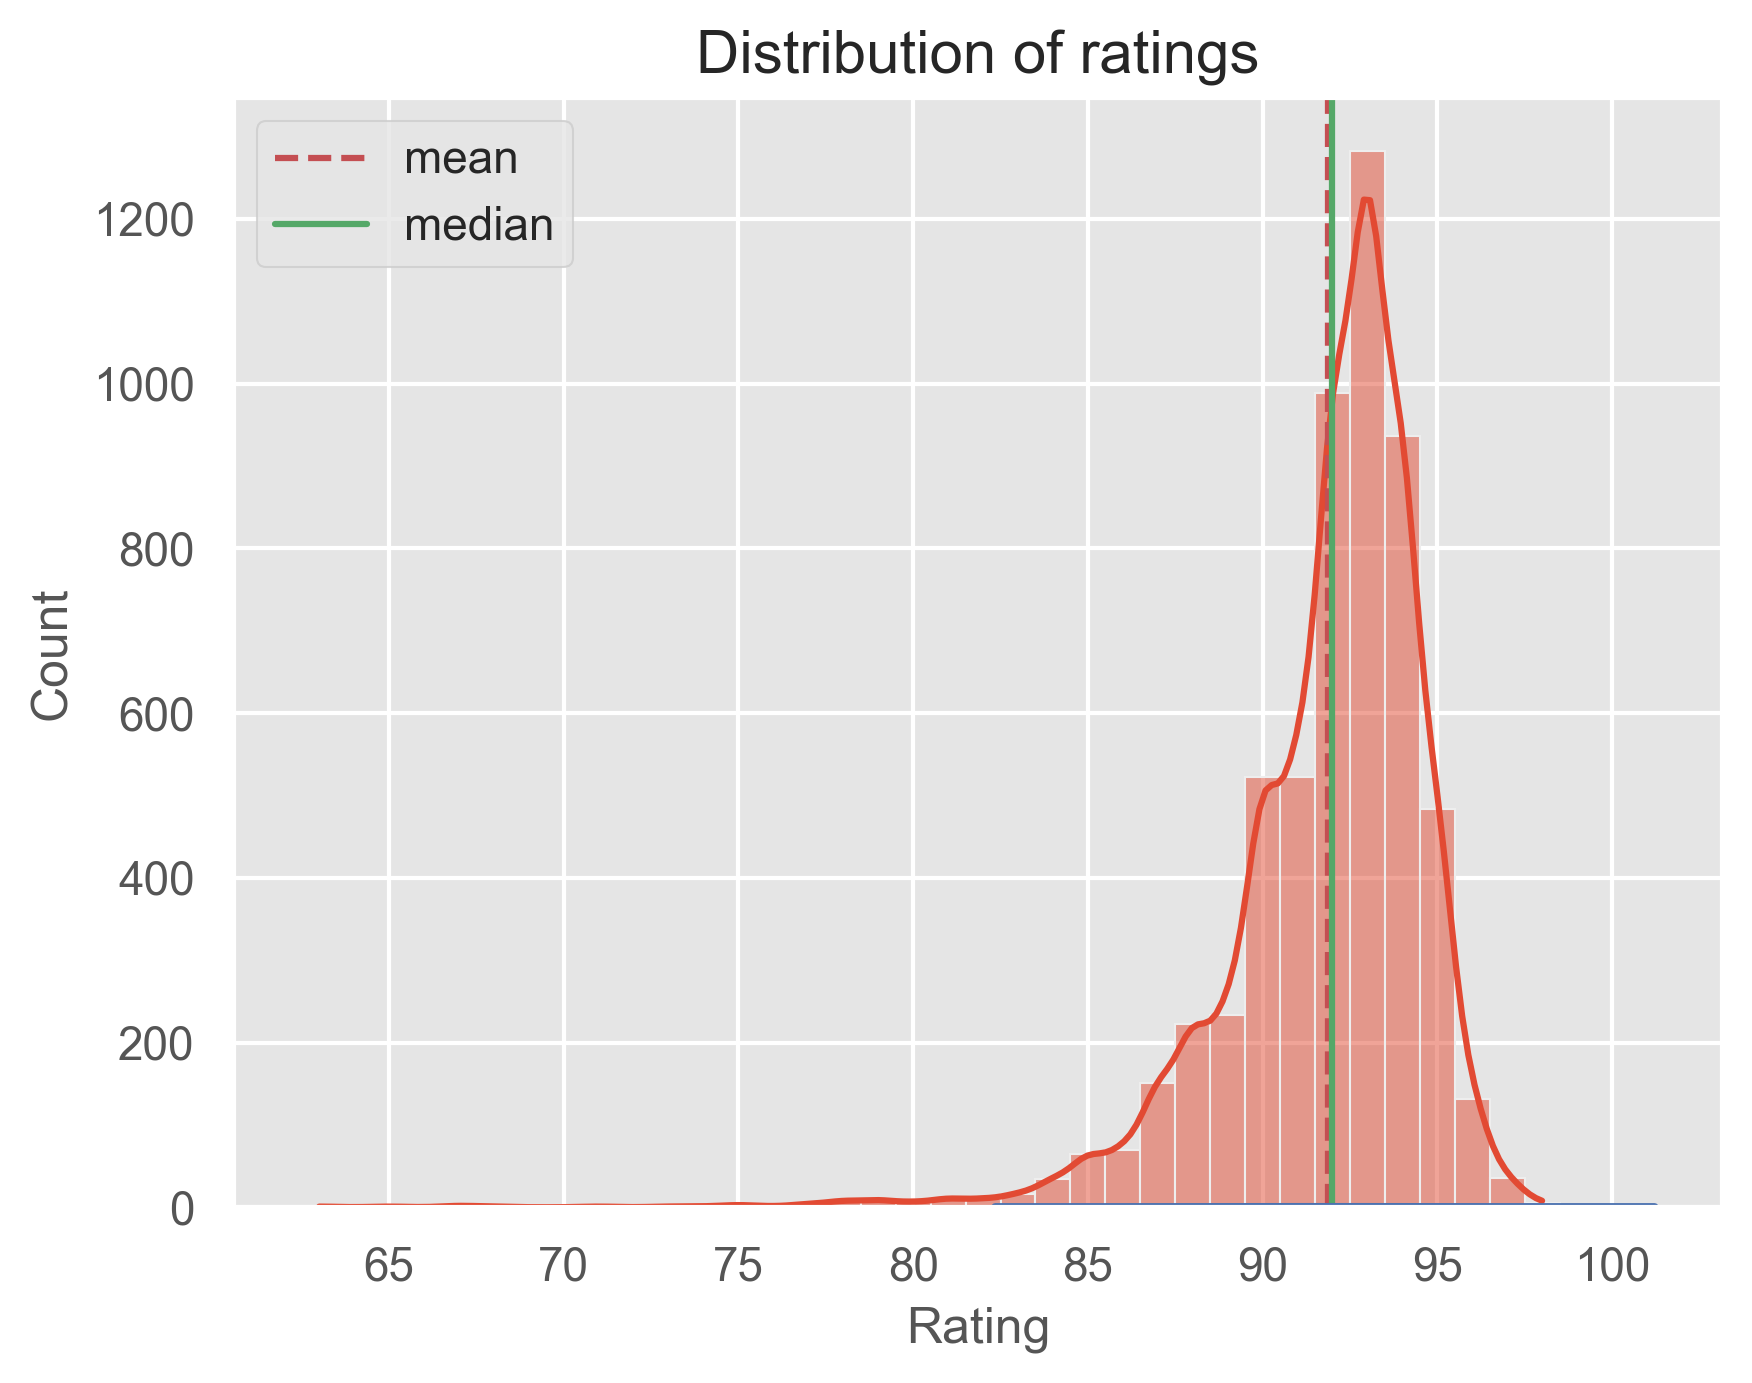

In [536]:
ax = sns.histplot(data=df.astype({'rating':'float'}), x='rating',kde=True, discrete=True)
ax.set_title('Distribution of ratings')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.axvline(df['rating'].mean(), color='r', linestyle='--', label='mean')
ax.axvline(df['rating'].median(), color='g', linestyle='-', label='median')
ax.legend()
plt.show()

<Axes: ylabel='origin_region'>

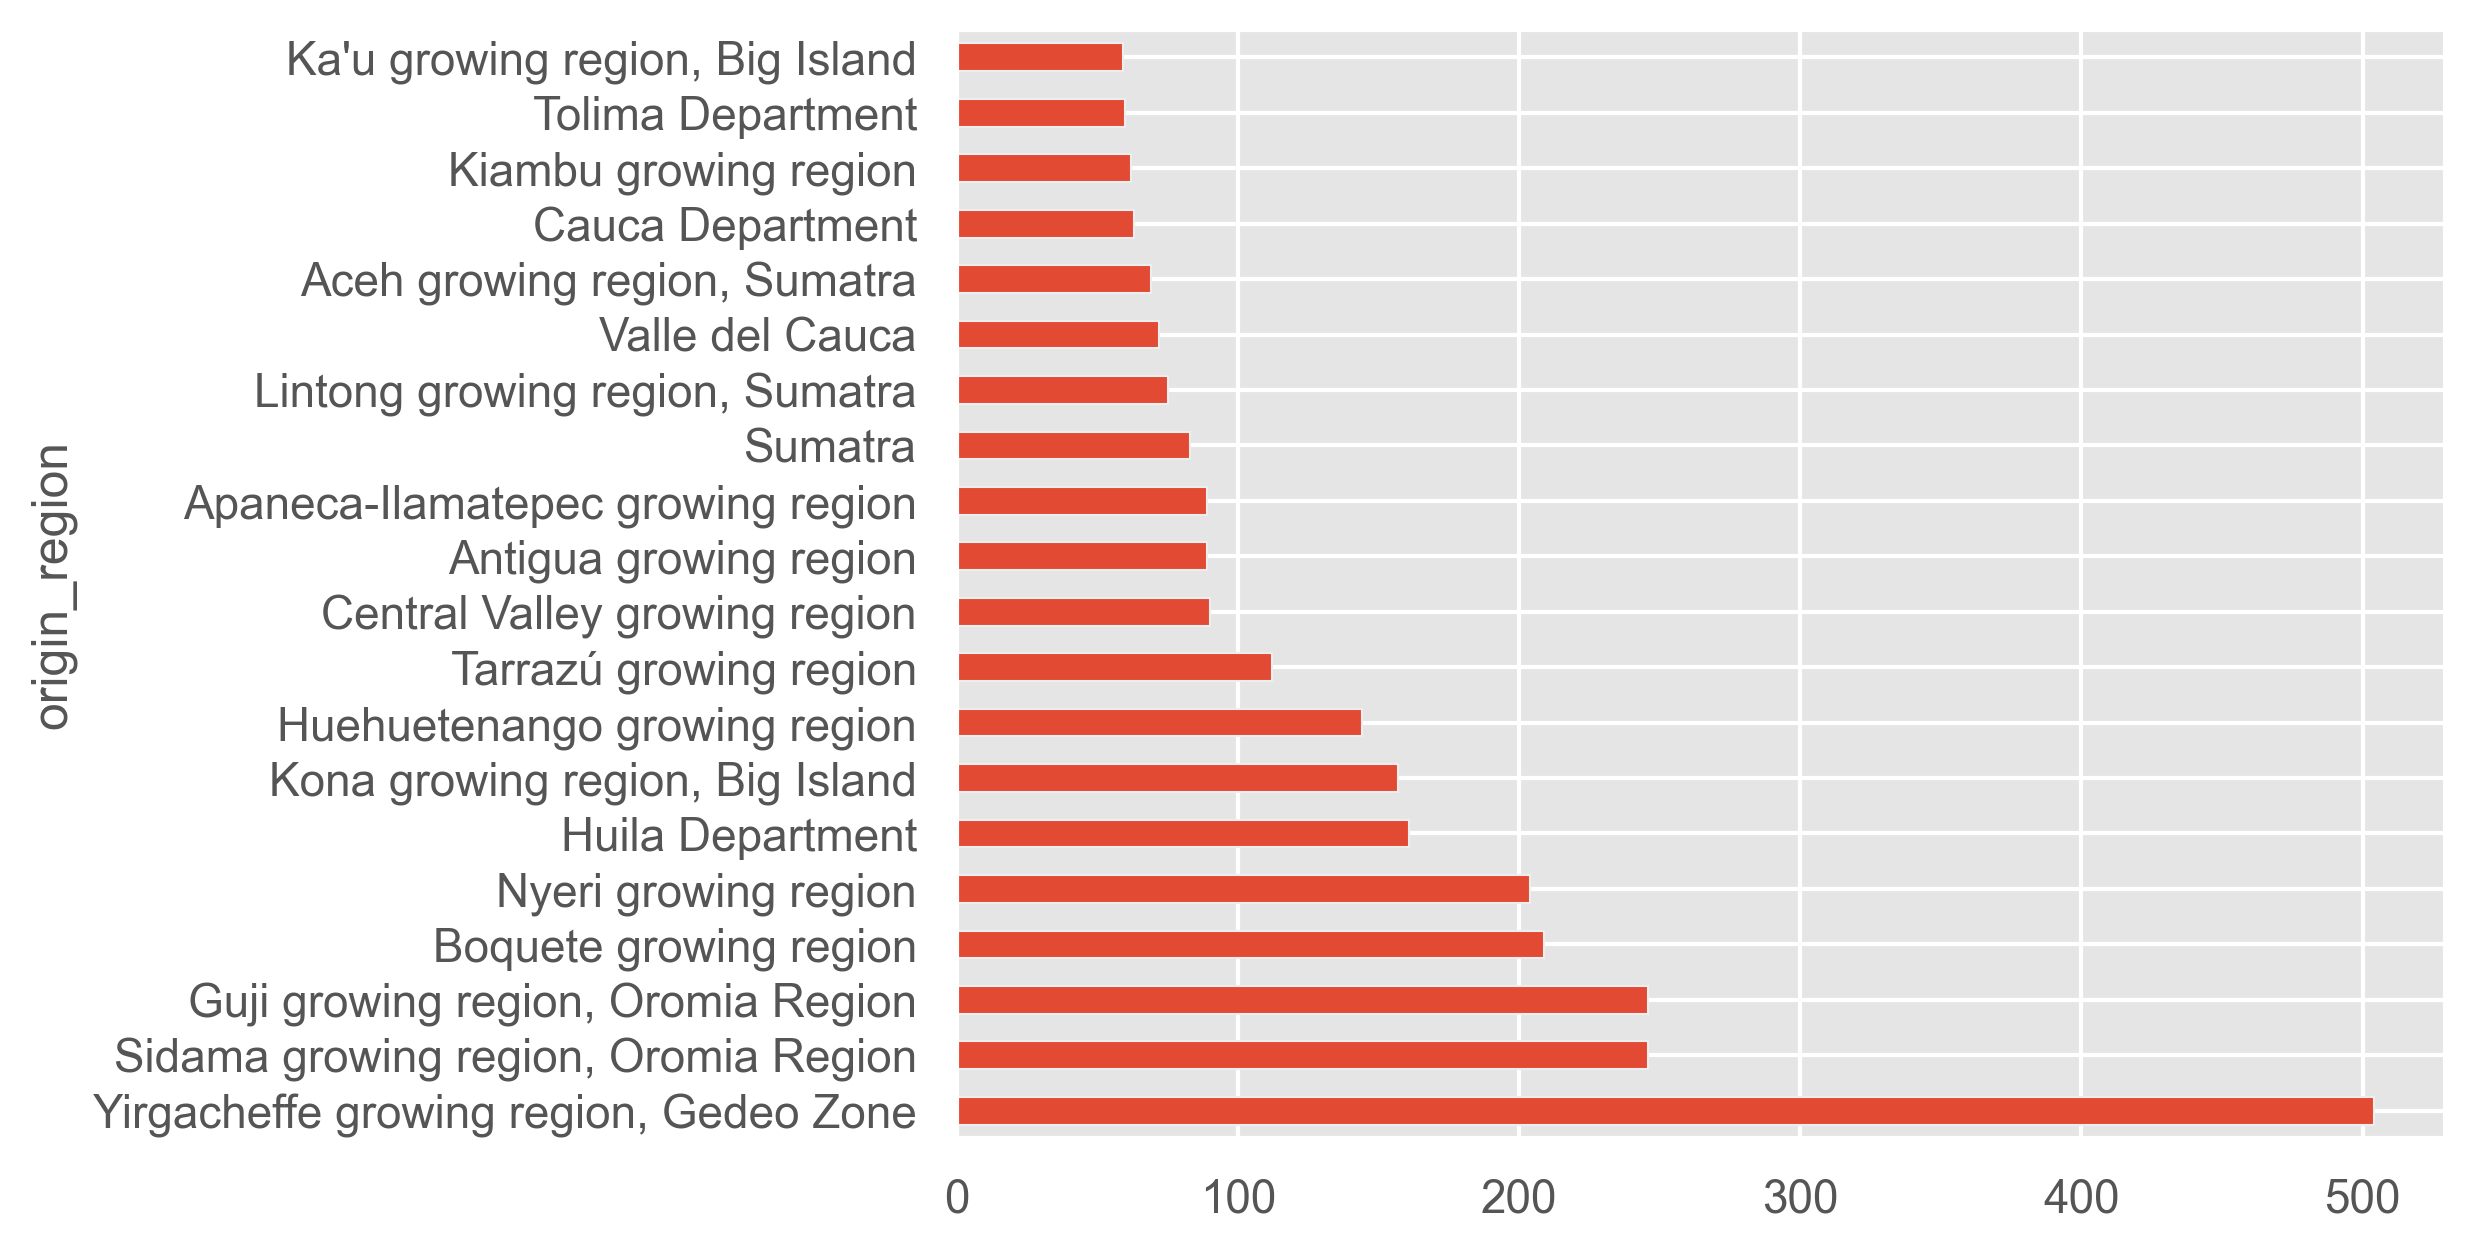

In [540]:
(df.select_dtypes())

In [547]:
df.columns


Index(['roaster_city', 'roaster_country', 'roaster_coordinates',
       'roaster_region', 'roaster_location_identifier', 'coffee_origin',
       'origin_country_cluster', 'roast_level', 'est_price', 'review_date',
       'aroma', 'body', 'flavor', 'aftertaste', 'rating', 'roaster', 'name',
       'blind_assessment', 'notes', 'url', 'acidity', 'origin_country',
       'origin_region', 'agtron_external', 'agtron_ground', 'quantity', 'unit',
       'quantity_grams', 'nominal_price', 'currency'],
      dtype='object')

In [555]:
# ratings over time 
# Correlations between rating and other variables, and price
# Price distribution
# Price by country
# Price by roaster location
# Price by origin region
# Cluster
# Roaster and origin country relationship
# Text analysis of reviews/descriptions

,roaster_city,roaster_country,roaster_coordinates,roaster_region,roaster_location_identifier,coffee_origin,origin_country_cluster,roast_level,est_price,review_date,...,acidity,origin_country,origin_region,agtron_external,agtron_ground,quantity,unit,quantity_grams,nominal_price,currency
0,Hong Kong,People's Republic of China,"22.278333333333,114.15861111111",People's Republic of China,Q8646,multiple,multiple,Medium-Light,CNY 160/250 grams,2023-11-01,...,8.0,multiple,NaN,60,78,250.0,grams,250.000,160.0,CNY
1,Madison,United States of America,"43.07472222222222,-89.38416666666667",Dane County,Q43788,"Nyeri growing region, south-central Kenya","Nyeri growing region, Kenya",Medium-Light,$22.00/12 ounces,2023-12-01,...,9.0,Kenya,Nyeri growing region,56,74,12.0,ounces,340.194,22.0,USD
2,Plymouth,United States of America,"41.95861111111111,-70.66777777777777",Plymouth County,Q326295,"Monte Verde, Santa Ana Department, central El ...","Apaneca-Ilamatepec growing region, El Salvador",Medium-Light,$16.00/12 ounces,2023-12-01,...,9.0,El Salvador,Apaneca-Ilamatepec growing region,58,74,12.0,ounces,340.194,16.0,USD
3,Madison,United States of America,"43.07472222222222,-89.38416666666667",Dane County,Q43788,"Tarrazu, Costa Rica","Tarrazú growing region, Costa Rica",Medium-Light,$18.00/8 ounces,2023-12-01,...,9.0,Costa Rica,Tarrazú growing region,59,77,8.0,ounces,226.796,18.0,USD
4,Peoria,United States of America,"40.6925,-89.59",Peoria County,Q233129,"Los Robles de Naranjo, West Valley, Costa Rica","West Valley growing region, Costa Rica",Medium-Light,$22.00/12 ounces,2023-12-01,...,8.0,Costa Rica,West Valley growing region,57,76,12.0,ounces,340.194,22.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8644,Berkeley,United States of America,"37.870277777778,-122.26805555556",Alameda County,Q484678,Sumatra,"Sumatra, Indonesia",Dark,NaN,1997-04-01,...,7.0,Indonesia,Sumatra,36,39,NaN,NaN,NaN,NaN,NaN
8653,Fort Bragg,United States of America,"39.445833333333,-123.80527777778",Mendocino County,Q579180,Colombia,Colombia,Medium-Dark,NaN,1997-02-01,...,4.0,Colombia,NaN,45,49,NaN,NaN,NaN,NaN,NaN
8665,Seattle,United States of America,"47.60621,-122.33207",King County,Q5083,"Indonesia, Central and South America",multiple,Medium-Dark,NaN,1997-02-01,...,6.0,multiple,NaN,47,52,NaN,NaN,NaN,NaN,NaN
8671,Branford,United States of America,"41.277777777778,-72.799722222222",South Central Connecticut Planning Region,Q898484,Kenya,Kenya,Medium-Dark,NaN,1997-03-01,...,8.0,Kenya,NaN,46,49,NaN,NaN,NaN,NaN,NaN
